In [1]:
# Import all of the python packages used in this workflow.
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd
import osgeo
import xarray as xr
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
import earthpy.spatial as es
import earthpy.plot as ep
import cartopy.crs as ccrs
import json
from datetime import datetime

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WY'


In [3]:
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/'
# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

inFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill'+domain+'/outputs/wo_assim/swed.gdat'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

nx = int(domains[domain]['ncols'])
ny = int(domains[domain]['nrows'])

xll = int(domains[domain]['xll'])
#xll = 4690100
yll = int(domains[domain]['yll'])
#yll = 487200
clsz = int(domains[domain]['cellsize'])


# model projection
mod_proj = domains[domain]['mod_proj']

#number of days
num_mod_timesteps= (datetime.strptime(domains[domain]['ed'],'%Y-%m-%d')- 
                    datetime.strptime(domains[domain]['st'],'%Y-%m-%d')).days

In [2]:
##USER INPUTS##
#start date
st = "2014-10-01"
#end date
ed = "2019-09-29"

#number of timesteps in model run 
num_mod_timesteps = 365 * 5

#model filename
#inFile = '/nfs/attic/dfh/Aragon2/CSOdata/swed.gdat'
inFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY/outputs/wo_assim/swed.gdat'
#from .ctl file
nx = 1382
ny = 2476
#ncols = 2476 
#nrows = 1382
xll = 487200
#xll = 4690100
yll = 4690100
#yll = 487200
clsz = 100

#model projection
mod_proj = 'epsg:32612' #UTM zone 12N

In [4]:
#Build lat/lon array 
#Longitudes
lons = np.arange(xll, xll+nx*clsz, clsz)
#Latitudes
lats = np.arange(yll, yll+ny*clsz, clsz)

In [5]:
len(lons), len(lats), len(lons)*len(lats)

(1382, 2476, 3421832)

In [6]:
nxy = len(lons)*len(lats)
nts = num_mod_timesteps # number of time steps to read

In [7]:
# open grads model output file into a numpy array 
with open(inFile, 'rb') as gradsfile:
    numpy_data = np.fromfile(inFile, dtype='float32', count=nts*nxy)
    numpy_data = np.reshape(numpy_data, (nts, ny, nx))

numpy_data.shape

(1824, 2476, 1382)

In [8]:
time = pd.date_range(st, periods=nts) # periods=num_mod_timesteps
time

DatetimeIndex(['2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04',
               '2014-10-05', '2014-10-06', '2014-10-07', '2014-10-08',
               '2014-10-09', '2014-10-10',
               ...
               '2019-09-19', '2019-09-20', '2019-09-21', '2019-09-22',
               '2019-09-23', '2019-09-24', '2019-09-25', '2019-09-26',
               '2019-09-27', '2019-09-28'],
              dtype='datetime64[ns]', length=1824, freq='D')

In [9]:
# convert to xarray DataArray
swe = xr.DataArray(
    numpy_data,
    dims=('time', 'y', 'x'), 
    coords={'time': time, 'y': lats, 'x': lons}
)
swe

<xarray.DataArray (time: 1824, y: 2476, x: 1382)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00022715,
         0.00024461, 0.00026013],
        [0.        , 0.        , 0.        , ..., 0.00014497,
         0.00016056, 0.00027433],
        [0.        , 0.        , 0.        , ..., 0.00015406,
         0.0001647 , 0.00028161]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00086902,
         0.00096331, 0.00104754],
        [0.        , 0.        , 0.        , ..., 0.00084729,
         0.00094985, 0.00112039],
        [0.        , 0.        , 0.        , ..., 0.0009052 ,
         0.00097502, 0.00115664]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2014-10-01 2014-10-02 ... 2019-09-28
  * y        (y) int64 4690100 4690200 4690300 ... 4937400 4937500 4937600
  * x        (x) int64 487200 487300 487400 487500 ... 625100 625200 625300

In [10]:
#full timeseries
sw = swe

In [ ]:
# select subset of days
# sw = swe[365:,:,:]
# sw

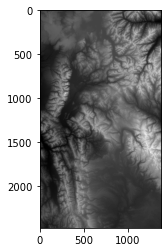

In [11]:
# DEM data
pathToRaster = r'/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
src = rio.open(pathToRaster)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
elevation = src.read(1)

#plot
x = plt.imshow(src.read(1), cmap='gray')
plt.show()

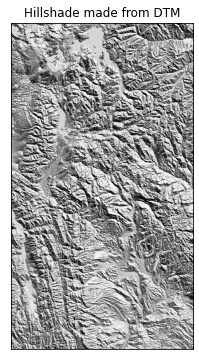

In [13]:
# Create and plot the hillshade with earthpy
hillshade = es.hillshade(elevation)

ep.plot_bands(
    hillshade, cbar=False, title="Hillshade made from DTM", figsize=(10, 6)
)
plt.show()

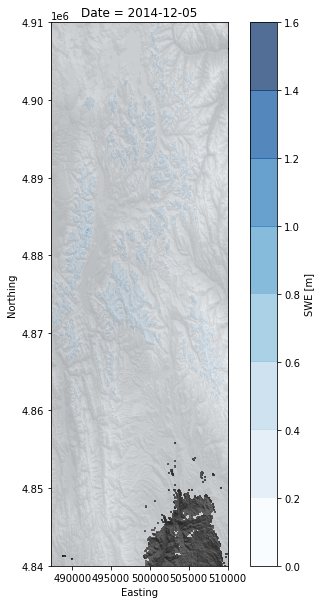

In [24]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
ax.imshow(np.flipud(hillshade), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

#add model output
inswe = np.squeeze(sw[65,:,:])
b = np.ma.masked_where(inswe< 0.01, inswe)
snow = ax.imshow(b, origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap =plt.cm.get_cmap('Blues', 8),alpha = 0.7)
snow.set_clim(0,1.6)

# #remove tickmarks and tick labels
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)

#colorbar
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('SWE [m]')

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

#date title
plt.title("Date = " + str(swe.coords['time'].values[65])[:10])



#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

In [ ]:
#raster to numpy array 
type(hillshade)

In [ ]:
src.meta

In [ ]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))
ax = plt.axes(projection=ccrs.PlateCarree())


plt.contourf(ln, lt, swe[60,:,:], transform=from_proj, extend='max', cmap="PuBu")
#hillshade and elevation
ax.plot(np.flipud(hillshade), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray',transform =ccrs.epsg(32612))
# ax.imshow(np.flipud(elevation), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

# #add model output
# inswe = np.squeeze(sw[65,:,:])
# b = np.ma.masked_where(inswe< 0.01, inswe)
# #snow = ax.imshow(b, origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap =plt.cm.get_cmap('Blues', 8),alpha = 0.7)
# #snow.set_clim(0,1.6)

# #colorbar
# ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
# ax_cbar.set_label('SWE [m]')

# ax.set_xlabel('Easting')
# ax.set_ylabel('Northing')

# #date title
# plt.title("Date = " + str(swe.coords['time'].values[65])[:10])

# To zoom in on data:
#plt.xlim(490000, 520000)
#plt.ylim(4800000, 4850000)

#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

In [35]:
#make the images for the movie
for i in range(np.shape(sw)[0]):
    print(i)

    # plot georeferenced SnowModel output with SNOTEL stations 
    fig, ax = plt.subplots(1,figsize=(8,10))

    #hillshade and elevation
    ax.imshow(np.flipud(hillshade), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray')
    ax.imshow(np.flipud(elevation), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

    #add model output
    inswe = np.squeeze(sw[i,:,:])
    b = np.ma.masked_where(inswe< 0.01, inswe)
    snow = ax.imshow(b, origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap =plt.cm.get_cmap('Blues', 8),alpha = 0.7)
    snow.set_clim(0,1.6)

#     #remove tickmarks and tick labels
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)

    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')

    #colorbar
    ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
    ax_cbar.set_label('SWE [m]')

    #date title
    plt.title("Date = " + str(sw.coords['time'].values[i])[:10])

    plt.savefig("/nfs/attic/dfh/Aragon2/CSOfigs/"+domain+f"/figs/Python_Animation_frame_{i:04}.png")
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
PNGpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/figs/Python_Animation_frame*.png'
GIFpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/figs/SM_Animation_cal.gif'

In [37]:
# make the movie
!convert $PNGpath $GIFpath

In [1]:
# make the movie
!convert /nfs/attic/dfh/Aragon2/CSOfigs/UT2/figs/Python_Animation_frame*.png /nfs/attic/dfh/Aragon2/CSOfigs/WY/figs/SM_Animation_cal.gif


In [ ]:
import ffmpeg
!ffmpeg -r 1 -i /nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/Python_Animation_02_frame*.png -pix_fmt yuv420p -r 10 /nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/SM_Animation.mp4